# Digits classification using HOG and SVM

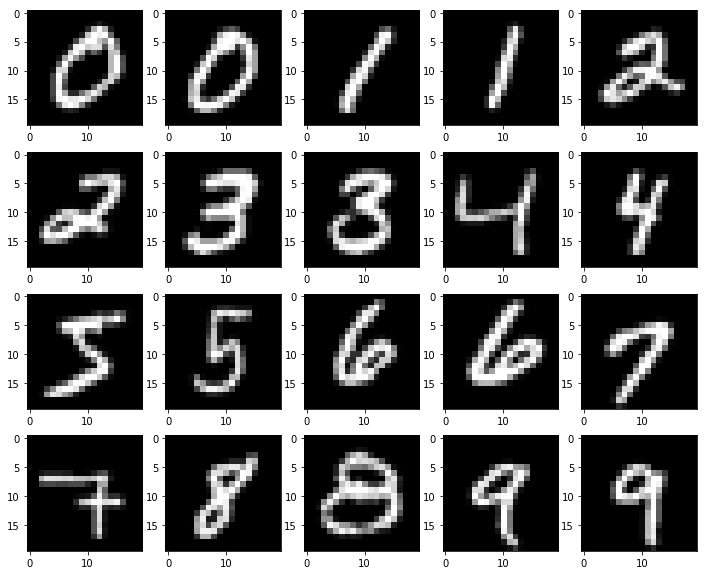

In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read digits images
original_img = cv2.imread('digits.png',0)
num_classes = 10
digit_size = 20               # Number of rows and columns of each digit
num_digits_per_class = 500

num_rows, num_cols = original_img.shape
num_digits_per_row = int(num_rows/digit_size)
num_digits_per_column = int(num_cols/digit_size)

# Get digits images from original image containing all digits
all_digit_images = []
for i in range(num_digits_per_row):
    for j in range(num_digits_per_column):
        digit_img = original_img[i*digit_size:(i+1)*digit_size, j*digit_size:(j+1)*digit_size]
        all_digit_images.append(digit_img)
        
# Show some digits
k = 0
plt.figure(figsize=(12,10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(all_digit_images[k], 'gray')
    k += num_digits_per_class//2

In [4]:
# Split dataset into training and testing
train_imgs = []
test_imgs = []
for i in range(num_classes):
    split_amount = int(num_digits_per_class/2)
    class_images = all_digit_images[i*num_digits_per_class:(i+1)*num_digits_per_class]
    train_imgs.extend(class_images[:num_digits_per_class//2])
    test_imgs.extend(class_images[num_digits_per_class//2:])

In [5]:
# Create and compute HOG descriptor
winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (5,5)
nbins = 9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

hog_data = [hog.compute(img) for img in train_imgs]
train_data = np.float32(hog_data).reshape(-1,len(hog_data[0]))
responses = np.repeat(np.arange(10),250).reshape(len(train_imgs), 1)

In [6]:
# Run SVM classifier on the descriptors
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
#svm.setC(2.67)           # If necessary, we can change the C parameter of the classifier
#svm.setGamma(5.383)
svm.train(train_data, cv2.ml.ROW_SAMPLE, responses)

# Test the accuracy of the classifier on the test data
hog_data = [hog.compute(img) for img in test_imgs]
test_data = np.float32(hog_data).reshape(-1,len(hog_data[0]))
result = svm.predict(test_data)[1]

# Check percentage of correct responses and print
mask = result==responses
correct = np.count_nonzero(mask)
print("Accuracy: {}%".format(correct*100.0/result.size))

Accuracy: 97.28%


In [27]:
# Run SVM from sklearn, doing a grid search for best parameters. Caution, takes a lot of time!
import sklearn.svm
from sklearn.model_selection import GridSearchCV

C_values = np.logspace(-1, 2, 10)
gamma_values = np.logspace(-2, 1, 10)
tuned_parameters = [{'kernel': ['linear'], 'C': C_values},
                    {'kernel': ['rbf'], 'C': C_values, 'gamma':gamma_values}]

svm = sklearn.svm.SVC()
clf = GridSearchCV(svm, tuned_parameters, scoring='accuracy', cv=5, n_jobs=5)
clf.fit(train_data, responses[:,0])
print(clf.best_score_)
print(clf.best_params_)
best_svm = clf.best_estimator_
best_svm.score(test_data, responses[:,0])

0.95960000000000001